# ResNet50

In [1]:
pip install kagglehub

In [2]:
pip install torch

# 2. Importowanie bibliotek i modułów
Ładowanie kluczowych bibliotek potrzebne do obsługi danych, procesowania obrazów, modelowania głębokiego uczenia oraz ewaluacji modelu. Wykorzystywane są tu torch i torchvision dla operacji na sieciach neuronowych i obrazach, w tym ładowanie modelu ResNet50. Funkcje jak DataLoader, WeightedRandomSampler, i random_split wspierają efektywne ładowanie i próbkowanie danych. transforms służy do przygotowania obrazów do modelowania. Biblioteki takie jak pandas dla operacji na danych, matplotlib dla wizualizacji, oraz sklearn.metrics dla metryk ewaluacyjnych ułatwiają zarządzanie i analizę wyników. tqdm dodaje pasek postępu dla operacji długotrwałych, a Counter pomaga w analizie rozkładu danych.








In [3]:
import kagglehub
import torch
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

#3. Pobranie zestawów danych

In [4]:
path_stanford_dogs = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
path_wolfs = kagglehub.dataset_download("harishvutukuri/dogs-vs-wolves")

print("Path to dataset files:", path_stanford_dogs)
print("Path to dataset files:", path_wolfs)

100%|██████████| 750M/750M [00:15<00:00, 52.2MB/s]

Extracting files...


100%|██████████| 222M/222M [00:02<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2
Path to dataset files: /root/.cache/kagglehub/datasets/harishvutukuri/dogs-vs-wolves/versions/2


In [5]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


# 4. Organizacja katalogów i integracja zestawów danych
W ramach tej operacji, dane z dwóch zestawów - stanford-dogs-dataset oraz dogs-vs-wolves - zostały zintegrowane poprzez przeniesienie obrazów wilków do katalogu obrazów psów. Za pomocą modułów os i shutil, w katalogu images utworzony został nowy podfolder wolf, gdzie umieszczono wszystkie obrazy wilków. Ta strukturalna organizacja danych pozwala na efektywniejsze zarządzanie i dostęp do wszystkich obrazów z obu zestawów w jednej lokalizacji, co ułatwia dalsze przetwarzanie i analizę danych.



In [6]:
import os
import shutil

base_dir = "data"
dogs_dir = os.path.join(path_stanford_dogs, "images/Images")
wolves_dir = os.path.join(path_wolfs, "data", "wolves")

def integrate_wolves_into_dogs(dogs_dir, wolves_dir):
    """
    Moves wolf images into the 'images' directory of the dogs dataset
    under a new folder named 'wolf'.
    """
    wolf_class_dir = os.path.join(dogs_dir, "wolf")
    os.makedirs(wolf_class_dir, exist_ok=True)

    for file_name in os.listdir(wolves_dir):
        src_path = os.path.join(wolves_dir, file_name)
        dest_path = os.path.join(wolf_class_dir, file_name)

        if os.path.isfile(src_path):
            shutil.move(src_path, dest_path)

    print(f"Wolves successfully moved into: {wolf_class_dir}")

integrate_wolves_into_dogs(dogs_dir, wolves_dir)


Wolves successfully moved into: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/wolf


# 5. Zastosowanie transformacji i próbkowania dla równoważenia zestawu danych
W projekcie zastosowano transformacje obrazów, takie jak zmiana rozmiaru, konwersja do tensorów oraz normalizacja, aby przygotować dane wejściowe do efektywnego trenowania modeli głębokiego uczenia, przy czym wykorzystanie GPU jako urządzenia docelowego znacząco przyspieszyło przetwarzanie. Dane zostały podzielone na zestawy treningowe, walidacyjne i testowe, co umożliwia odpowiednią ocenę modelu na różnych etapach uczenia. Dodatkowo, przygotowano próbnik z wagami za pomocą WeightedRandomSampler do równoważenia klas w zestawie treningowym, co zapobiega dominacji liczniejszych klas i poprawia zdolność modelu do generalizacji. Zdefiniowane DataLoader dla każdego zestawu danych gwarantują efektywne ładowanie i przetwarzanie danych w procesie treningu, walidacji i testowania modelu.

In [7]:
device = torch.device("cuda")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def prepare_dataset(dogs_dir, transform):

    dog_dataset = datasets.ImageFolder(dogs_dir, transform=transform)


    train_size = int(0.7 * len(dog_dataset))
    val_size = int(0.15 * len(dog_dataset))
    test_size = len(dog_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dog_dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset



train_dataset, val_dataset, test_dataset = prepare_dataset(dogs_dir, transform)



def create_sampler(dataset):
    all_classes = range(len(dataset.dataset.classes))
    class_names = dataset.dataset.classes  # Class names from ImageFolder

    class_counts = Counter(dataset.dataset.targets[i] for i in dataset.indices)

    for cls in all_classes:
        if cls not in class_counts:
            class_counts[cls] = 0

    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

    sample_weights = [class_weights[dataset.dataset.targets[i]] for i in dataset.indices]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    weight_df = pd.DataFrame({
        'Class': class_names,
        'Count': [class_counts[cls] for cls in all_classes],
        'Weight': [class_weights[cls] for cls in all_classes]
    })

    return sampler,weight_df

train_sampler,classes_weights = create_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


In [8]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [9]:
classes_weights

,Class,Count,Weight
0,n02085620-Chihuahua,102,0.009804
1,n02085782-Japanese_spaniel,133,0.007519
2,n02085936-Maltese_dog,179,0.005587
3,n02086079-Pekinese,95,0.010526
4,n02086240-Shih-Tzu,147,0.006803
...,...,...,...
116,n02113978-Mexican_hairless,103,0.009709
117,n02115641-dingo,114,0.008772
118,n02115913-dhole,108,0.009259
119,n02116738-African_hunting_dog,126,0.007937


#6. Konfiguracja i trening modelu ResNet50

Konfiguracja i trening modelu ResNet50: Projekt wykorzystuje model ResNet50 z domyślnymi wagami, dostosowany do zadania poprzez zmianę warstwy wyjściowej na odpowiadającą liczbie klas. Model operuje na GPU dla zwiększenia wydajności.

Trening używa funkcji straty CrossEntropyLoss i optymalizatora Adam. Funkcja train_model realizuje trening przez określoną liczbę epok, z możliwością wcześniejszego zakończenia przy braku postępów. W trakcie treningu następuje ewaluacja modelu na danych walidacyjnych, gdzie obliczana jest strata, dokładność oraz wynik F1, istotny dla oceny modelu przy niezbalansowanych klasach.

Najlepszy model jest zapisywany i wykorzystywany w dalszym procesie, co gwarantuje użycie najbardziej efektywnego wariantu w praktycznych zastosowaniach.

In [11]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_classes = len(train_dataset.dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }
    best_f1 = 0.0
    no_improvement = 0
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        val_predictions, val_targets = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_predictions.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        f1 = f1_score(val_targets, val_predictions, average="weighted")

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(f1)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_model_path)
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    print(f"Best Validation F1-Score: {best_f1:.4f}")
    return history


history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.5MB/s]
Epoch 1/10: 100%|██████████| 119/119 [03:28<00:00,  1.75s/batch, loss=4.69]


Epoch 1/10 - Train Loss: 1.5060, Val Loss: 1.5595, Val Accuracy: 0.5514, Val F1-Score: 0.5486


Epoch 2/10: 100%|██████████| 119/119 [03:33<00:00,  1.79s/batch, loss=4.17]


Epoch 2/10 - Train Loss: 0.7784, Val Loss: 1.8490, Val Accuracy: 0.5236, Val F1-Score: 0.5313


Epoch 3/10: 100%|██████████| 119/119 [03:34<00:00,  1.80s/batch, loss=4.51]


Epoch 3/10 - Train Loss: 0.5518, Val Loss: 1.4759, Val Accuracy: 0.6111, Val F1-Score: 0.6176


Epoch 4/10: 100%|██████████| 119/119 [03:32<00:00,  1.79s/batch, loss=5.09]


Epoch 4/10 - Train Loss: 0.4557, Val Loss: 1.4191, Val Accuracy: 0.6305, Val F1-Score: 0.6308


Epoch 5/10: 100%|██████████| 119/119 [03:33<00:00,  1.79s/batch, loss=5.04]


Epoch 5/10 - Train Loss: 0.3472, Val Loss: 1.5760, Val Accuracy: 0.6163, Val F1-Score: 0.6162


Epoch 6/10: 100%|██████████| 119/119 [03:33<00:00,  1.80s/batch, loss=5.5]


Epoch 6/10 - Train Loss: 0.3286, Val Loss: 1.4455, Val Accuracy: 0.6274, Val F1-Score: 0.6290


Epoch 7/10: 100%|██████████| 119/119 [03:32<00:00,  1.78s/batch, loss=4.84]


Epoch 7/10 - Train Loss: 0.2899, Val Loss: 1.5299, Val Accuracy: 0.6324, Val F1-Score: 0.6300


Epoch 8/10: 100%|██████████| 119/119 [03:32<00:00,  1.79s/batch, loss=5.66]


Epoch 8/10 - Train Loss: 0.3522, Val Loss: 1.5527, Val Accuracy: 0.6228, Val F1-Score: 0.6257


Epoch 9/10: 100%|██████████| 119/119 [03:31<00:00,  1.77s/batch, loss=3.6]


Epoch 9/10 - Train Loss: 0.2832, Val Loss: 1.6169, Val Accuracy: 0.6033, Val F1-Score: 0.6080
Early stopping at epoch 9
Best Validation F1-Score: 0.6308


Podczas trenowania modelu ResNet50 z użyciem wstępnie nauczonych wag, obserwujemy zmienne wyniki w trakcie 9 epok treningu przed wczesnym zakończeniem procesu z powodu braku postępu. Strata treningowa konsekwentnie spada, zaczynając od 1.5060 w pierwszej epoce, co wskazuje na skuteczne uczenie się. Najlepsze wyniki na zestawie walidacyjnym osiągnięto w epoce 7, gdzie dokładność wyniosła 63.24% a wynik F1 0.6308, co jest najwyższą zanotowaną wartością dla tego miernika. Trening zatrzymano przedwcześnie w 9 epoce z powodu braku dalszej poprawy, co jest częścią strategii mającej na celu zapobieganie nadmiernemu dopasowaniu do danych treningowych.

# 7. Ewaluacja modelu ResNet50 na zestawie testowym
 Funkcja test_model ocenia model na zestawie testowym, przechodząc przez dane bez aktualizacji wag. Wykorzystuje softmax do obliczania prawdopodobieństw klasyfikacji, z którego ekstrahuje przewidywania i prawdziwe etykiety. Na koniec oblicza ważony wynik F1 i AUC dla oceny dokładności modelu w klasyfikacji wieloklasowej.

Dodatkowo, funkcja generuje raport klasyfikacji i macierz pomyłek, które dostarczają szczegółowych informacji o wynikach dla każdej klasy, ułatwiając analizę i zrozumienie wydajności modelu.

In [12]:
def test_model(model, test_loader):
    model.eval()
    all_predictions, all_targets = [], []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())


    f1 = f1_score(all_targets, all_predictions, average="weighted")


    n_classes = len(test_loader.dataset.dataset.classes)
    all_targets_one_hot = torch.nn.functional.one_hot(
        torch.tensor(all_targets), num_classes=n_classes
    ).numpy()


    auc = roc_auc_score(
        y_true=all_targets_one_hot,
        y_score=all_probabilities,
        multi_class="ovr",
        average="weighted"
    )

    class_names = test_loader.dataset.dataset.classes
    report = classification_report(
        all_targets,
        all_predictions,
        target_names=class_names,
        output_dict=True
    )

    report_df = pd.DataFrame(report).transpose()

    confusion = confusion_matrix(all_targets, all_predictions)
    confusion_df = pd.DataFrame(confusion, index=class_names, columns=class_names)

    print(f"Test F1-Score: {f1:.4f}, Test AUC: {auc:.4f}")

    return f1, auc, report_df, confusion_df

f1, auc, report_df, confusion_df = test_model(model, test_loader)


Testing: 100%|██████████| 26/26 [00:25<00:00,  1.04batch/s]

Test F1-Score: 0.6394, Test AUC: 0.9891


Wizualizacja historii treningu modelu

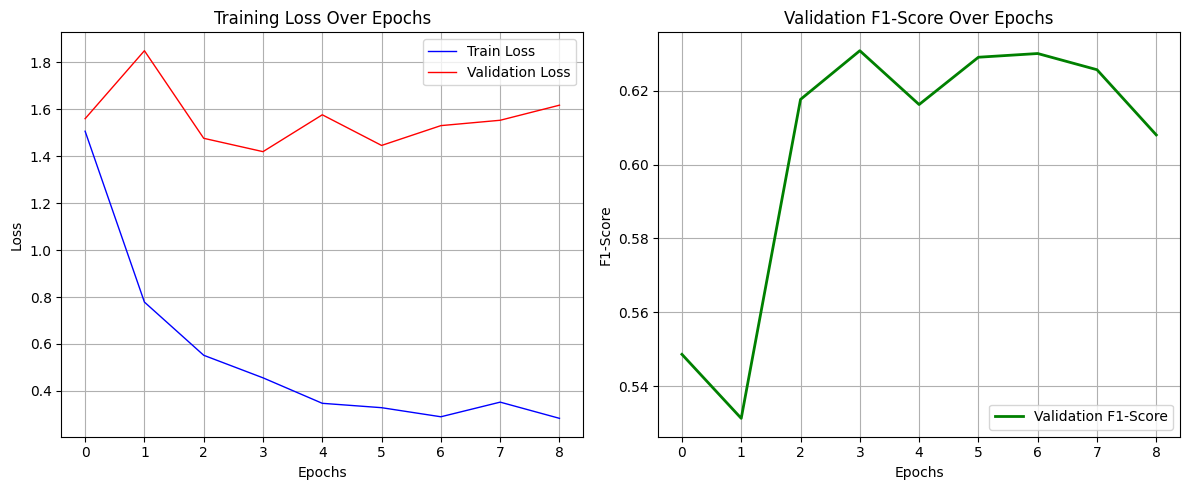

In [13]:

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=1)
    plt.plot(history['val_loss'], label='Validation Loss', color='red', linewidth=1)

    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Validation F1-Score', color='green', linewidth=2)
    plt.title('Validation F1-Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [14]:
report_df

,precision,recall,f1-score,support
n02085620-Chihuahua,0.631579,0.461538,0.533333,26.000000
n02085782-Japanese_spaniel,0.709677,0.846154,0.771930,26.000000
n02085936-Maltese_dog,0.736842,0.700000,0.717949,40.000000
n02086079-Pekinese,0.916667,0.407407,0.564103,27.000000
n02086240-Shih-Tzu,0.600000,0.352941,0.444444,34.000000
...,...,...,...,...
n02116738-African_hunting_dog,0.944444,0.772727,0.850000,22.000000
wolf,0.904110,0.857143,0.880000,154.000000
accuracy,0.636504,0.636504,0.636504,0.636504
macro avg,0.669873,0.630064,0.624971,3238.000000
